# Example Notebook 4: Landcover analysis

Here we run through some new features and provide another example of how some tools can be used. For our quick example here we are going to suppose we want to use analyse some landuse/landcover raster data. This could be using an off-the-shelf data product or the output from a model, but for this example we will use the former an take a look at some products from the Copernicus Land Monitoring Service:

* [Corine Land Cover](https://land.copernicus.eu/pan-european/corine-land-cover)
* [Grassland Status Map](https://land.copernicus.eu/pan-european/high-resolution-layers/grassland/status-maps)
* [Forest Type Status Map](https://land.copernicus.eu/pan-european/high-resolution-layers/forests/forest-type-1/status-maps)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx

import yt
import yt.extensions.georaster as gr

## Inspect the data

In [2]:
# data paths
lc_raster_path = Path("example-data/landcover-data/")
lc_rasters = [str(f) for f in sorted(lc_raster_path.glob("*.tif"))]

In [4]:
# load as one dataset
ds = yt.load(*lc_rasters, crs="epsg:27700")
# ds = yt.load(*lc_rasters, crs="epsg:27700", scale_factor=10)

yt : [INFO     ] 2022-08-24 15:33:40,553 Resampling using 'nearest' method.
yt : [INFO     ] 2022-08-24 15:33:40,754 Dataset CRS EPSG:27700 units are 'metre'. 
yt : [INFO     ] 2022-08-24 15:33:40,815 Parameters: domain_dimensions         = [ 8029 13393     1]
yt : [INFO     ] 2022-08-24 15:33:40,816 Parameters: domain_left_edge          = [-111074.70919852  -98696.5841344        0.        ] m
yt : [INFO     ] 2022-08-24 15:33:40,817 Parameters: domain_right_edge         = [6.91825291e+05 1.24060342e+06 1.00000000e+00] m


In [5]:
ds.field_list

[('CLC2018_V2020_20u1', 'band_1'),
 ('FTY_2018_010m_E34N37_03035_v010', 'band_1'),
 ('FTY_2018_010m_E35N37_03035_v010', 'band_1'),
 ('GRA_2018_010m_E34N37_03035_v010', 'band_1'),
 ('GRA_2018_010m_E35N37_03035_v010', 'band_1'),
 ('WAW_2018_010m_E34N37_03035_v020', 'band_1'),
 ('WAW_2018_010m_E35N37_03035_v020', 'band_1')]

In [6]:
geometries_path = Path("example-data/geometries/")

In [7]:
edinburgh = gpd.read_file(geometries_path / "edinburgh_lad.shp")
msoa = gpd.read_file(geometries_path / "edinburgh_msoa_geometries.shp")

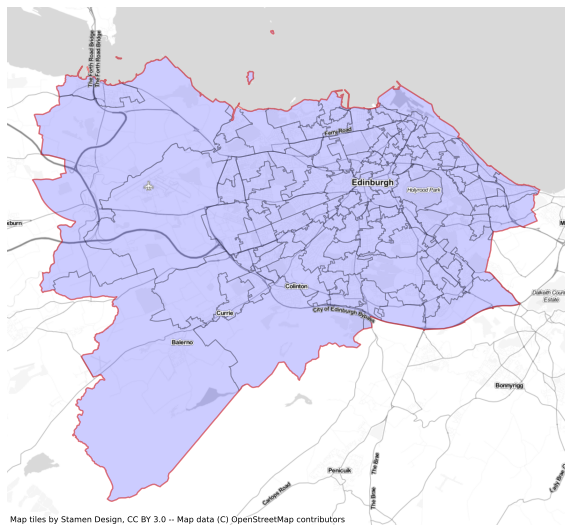

In [8]:
ax = msoa.to_crs("epsg:3857").plot(color="blue", figsize=(10, 10), alpha=0.2, edgecolor="black")
ax = edinburgh.to_crs("epsg:3857").boundary.plot(color="red", ax=ax, alpha=0.4)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.set_axis_off()

In [9]:
edinburgh.total_bounds

array([309580.7023, 659268.9957, 332793.3032, 680648.5959])

In [10]:
bounds = edinburgh.total_bounds
rectangle = ds.rectangle(ds.arr(bounds[:2], 'm'), ds.arr(bounds[2:], 'm'), clip=False)

Warning 1: The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
yt : [INFO     ] 2022-08-24 15:33:49,734 Reprojecting ('CLC2018_V2020_20u1', 'band_1'): PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NOR


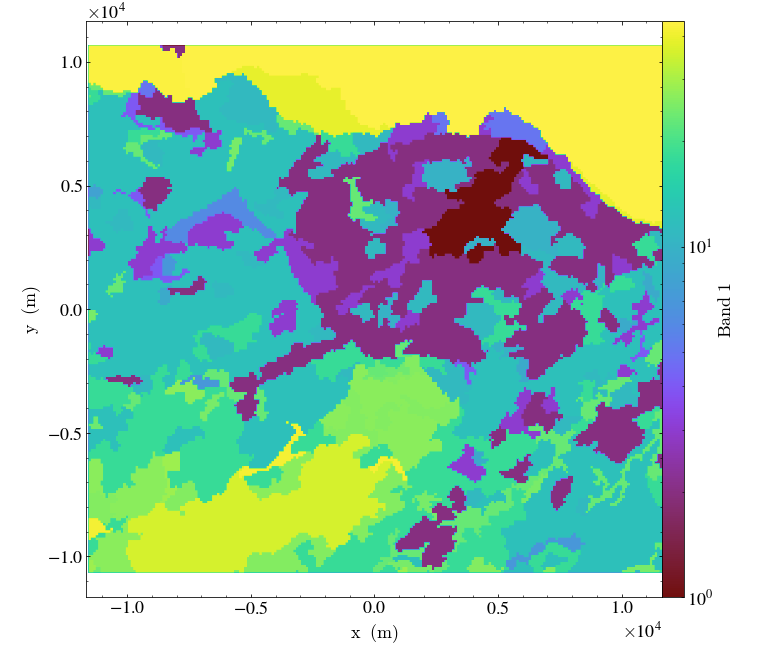

In [11]:
# CLC
p = ds.plot(('CLC2018_V2020_20u1', 'band_1'), data_source=rectangle)
p.show()

In [12]:
clc_categories = {
    "Parks": [10],
    "Leisure Facilities":[11],
    "Farmland": [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    "Woodland": [22, 23, 24, 25, 28, 29],
    "Grassland and Moors": [26, 27, 36]
}

In [13]:
# grassland
def _gra(field, data):
    return (np.isin(data[('GRA_2018_010m_E34N37_03035_v010', 'band_1')], [1]) | \
           np.isin(data[('GRA_2018_010m_E35N37_03035_v010', 'band_1')], [1]) |
           np.isin(data[('CLC2018_V2020_20u1', 'band_1')], clc_categories["Grassland and Moors"])).astype(int).astype(float)
# Add grassland to derivable fields list
ds.add_field(("category", "gra"), function=_gra,
             units="", display_name="Grassland and Moors", take_log=False, sampling_type='local', force_override=True)

Warning 1: The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
yt : [INFO     ] 2022-08-24 15:33:50,649 Reprojecting ('CLC2018_V2020_20u1', 'band_1'): PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NOR


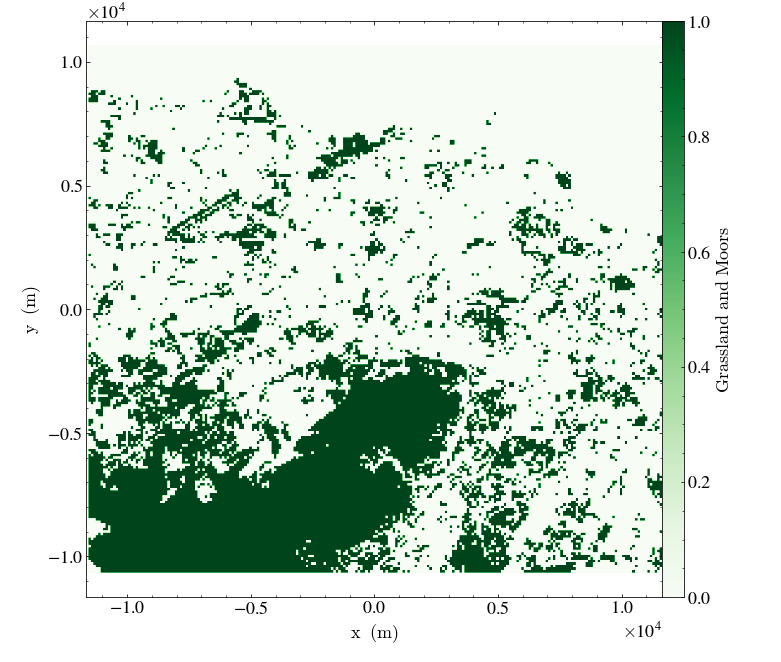

In [14]:
gd = ("category", "gra")
p = ds.plot(gd, data_source=rectangle)
p.set_cmap(gd, 'Greens')
p.show()

In [15]:
# forest
def _fty(field, data):
    return (np.isin(data[('FTY_2018_010m_E34N37_03035_v010', 'band_1')], [1, 2]) | \
           np.isin(data[('FTY_2018_010m_E35N37_03035_v010', 'band_1')], [1, 2]) |
           np.isin(data[('CLC2018_V2020_20u1', 'band_1')], clc_categories["Woodland"])).astype(int).astype(float)
# Add forests to derivable fields list
ds.add_field(("category", "fty"), function=_fty,
             units="", display_name='Forests', take_log=False, sampling_type='local', force_override=True)

Warning 1: The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
yt : [INFO     ] 2022-08-24 15:33:51,691 Reprojecting ('CLC2018_V2020_20u1', 'band_1'): PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NOR


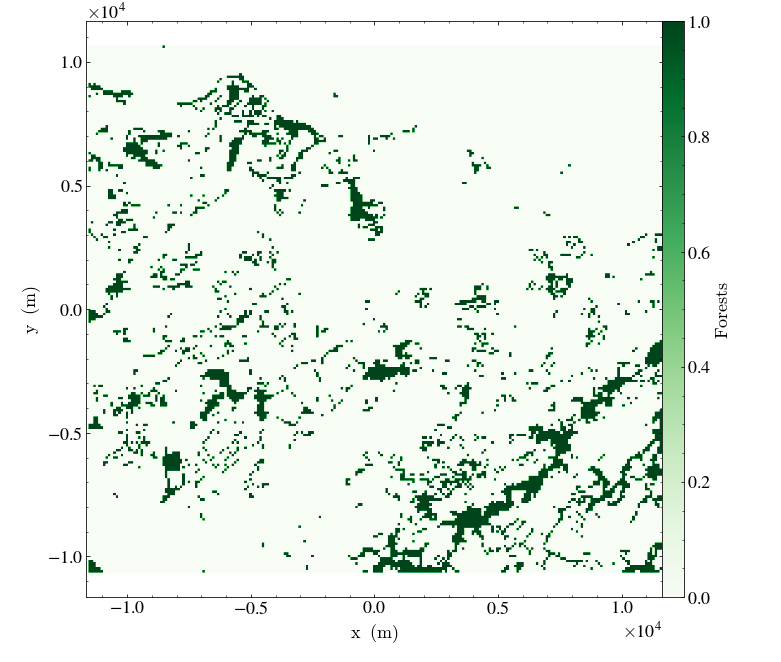

In [16]:
fs = ("category", "fty")
p = ds.plot(fs, data_source=rectangle)
p.set_cmap(fs, 'Greens')
p.show()

In [17]:
# parks
def _parks(field, data):
    return (np.isin(data[('CLC2018_V2020_20u1', 'band_1')], clc_categories["Parks"])).astype(int).astype(float)
ds.add_field(("category", "parks"), function=_parks,
             units="", display_name='Parks', take_log=False, sampling_type='local', force_override=True)
# Leisure Facilities
def _leisure(field, data):
    return (np.isin(data[('CLC2018_V2020_20u1', 'band_1')], clc_categories["Leisure Facilities"])).astype(int).astype(float)
ds.add_field(("category", "leisure"), function=_leisure,
             units="", display_name='Leisure Facilities', take_log=False, sampling_type='local', force_override=True)
# Farmland
def _farm(field, data):
    return (np.isin(data[('CLC2018_V2020_20u1', 'band_1')], clc_categories["Farmland"])).astype(int).astype(float)
ds.add_field(("category", "farm"), function=_farm,
             units="", display_name='Farmland', take_log=False, sampling_type='local', force_override=True)

In [18]:
# landcover
def _lc(field, data):
    fty = data[("category", "fty")].copy()
    gra = data[("category", "gra")].copy()
    parks =  data[("category", "parks")].copy()
    leisure =  data[("category", "leisure")].copy()
    farm = data[("category", "farm")].copy()
    output = np.zeros(fty.shape, dtype=int)
    output[farm.astype(bool)] = 3
    output[fty.astype(bool)] = 4
    output[gra.astype(bool)] = 5
    output[leisure.astype(bool)] = 2
    output[parks.astype(bool)] = 1
    
    return output.astype(float)
# Add landcover to derivable fields list
ds.add_field(("category", "lc"), function=_lc,
             units="", display_name='Landcover', take_log=False, sampling_type='local', force_override=True)

Warning 1: The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
yt : [INFO     ] 2022-08-24 15:33:52,625 Reprojecting ('CLC2018_V2020_20u1', 'band_1'): PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NOR


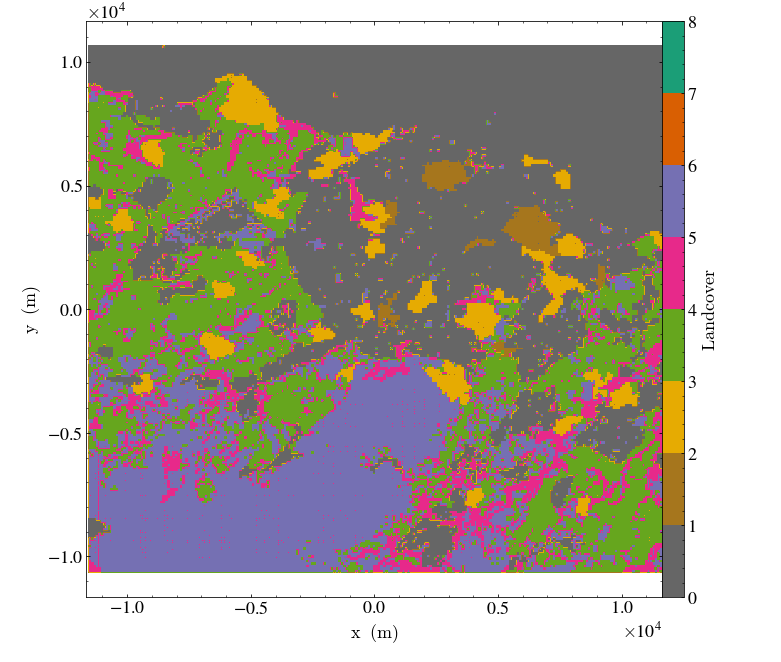

In [19]:
lc = ("category", "lc")
p = ds.plot(lc, data_source=rectangle)
p.set_zlim(lc, 0., 8)
p.set_cmap(lc, 'Dark2_r')
p.show()

Our mapping from above:

0 : Other

1 : Parks

2 : Leisure

3 : Farmland

4 : Woodland

5 : Grassland and Moors

## Analysis

In [20]:
mapping = {
    0: "Other",
    1: "Parks",
    2: "Leisure",
    3: "Farmland",
    4: "Woodland",
    5: "Grassland and Moors"
}

In [21]:
# full area's data
df = rectangle.to_dataframe(lc)
df["lc"] = df.lc.apply(lambda x: mapping[int(x)])
df.value_counts() * 100 / len(df)

Warning 1: The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
yt : [INFO     ] 2022-08-24 15:33:53,516 Reprojecting ('CLC2018_V2020_20u1', 'band_1'): PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NOR

lc                 
Other                  40.053829
Grassland and Moors    25.382467
Farmland               21.248179
Woodland                7.125223
Leisure                 4.775781
Parks                   1.414522
dtype: float64

### Calculate for all polygons

In [22]:
msoas = ds.polygons(msoa.geometry.values)

yt : [INFO     ] 2022-08-24 15:33:53,999 Number of features in poly object: 1
yt : [INFO     ] 2022-08-24 15:33:54,003 Number of features in poly object: 2
yt : [INFO     ] 2022-08-24 15:33:54,004 Number of features in poly object: 1
yt : [INFO     ] 2022-08-24 15:33:54,009 Number of features in poly object: 2
yt : [INFO     ] 2022-08-24 15:33:54,009 Number of features in poly object: 1
yt : [INFO     ] 2022-08-24 15:33:54,019 Number of features in poly object: 2
yt : [INFO     ] 2022-08-24 15:33:54,020 Number of features in poly object: 1
yt : [INFO     ] 2022-08-24 15:33:54,021 Number of features in poly object: 2
yt : [INFO     ] 2022-08-24 15:33:54,022 Number of features in poly object: 1
yt : [INFO     ] 2022-08-24 15:33:54,032 Number of features in poly object: 4
yt : [INFO     ] 2022-08-24 15:33:54,033 Number of features in poly object: 1


In [23]:
results = []
for name, poly in zip(list(msoa.InterZone), msoas):
    df = poly.to_dataframe(lc)
    df["lc"] = df.lc.apply(lambda x: mapping[int(x)])
    results.append((df.value_counts() * 100 / len(df)).to_dict())
    

Warning 1: The definition of projected CRS EPSG:3035 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
yt : [INFO     ] 2022-08-24 15:33:54,053 Reprojecting ('CLC2018_V2020_20u1', 'band_1'): PROJCS["ETRS_1989_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NOR

In [24]:
df = pd.DataFrame(results).fillna(0)
df

,"(Grassland and Moors,)","(Farmland,)","(Woodland,)","(Other,)","(Leisure,)","(Parks,)"
0,59.528024,24.110128,8.770895,5.703048,1.887906,0.0
1,19.264069,47.186147,8.874459,23.268398,1.406926,0.0
2,15.412186,19.713262,5.376344,42.293907,17.204301,0.0
3,4.294479,2.453988,6.748466,79.754601,6.748466,0.0
4,58.711770,16.821131,7.228916,10.518999,6.719184,0.0
...,...,...,...,...,...,...
106,6.024096,13.493976,0.722892,79.759036,0.000000,0.0
107,16.144019,47.154472,7.278358,22.725513,6.697638,0.0
108,7.126799,55.732914,11.937950,14.815647,10.386691,0.0
109,3.404255,17.872340,5.531915,73.191489,0.000000,0.0


<AxesSubplot:ylabel='Frequency'>

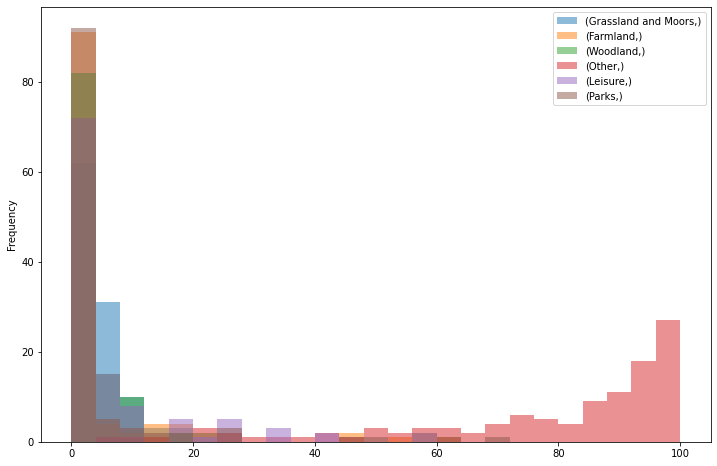

In [25]:
df.plot.hist(bins=25, alpha=0.5, figsize=(12, 8))

In [29]:
df["Green"] = df[('Woodland',)] + df[('Leisure',)] +  df[('Parks',)] +  df[('Grassland and Moors',)] + df[('Farmland',)]

<AxesSubplot:ylabel='Frequency'>

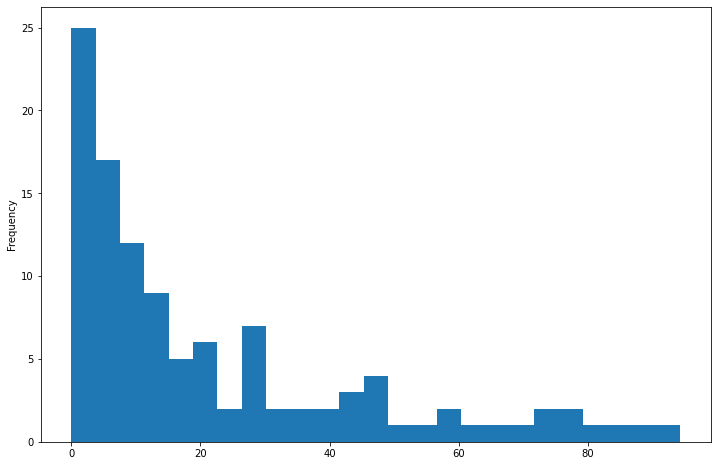

In [34]:
df["Green"].plot.hist(bins=25, figsize=(12, 8))

In [30]:
msoa["Green"] = df["Green"]

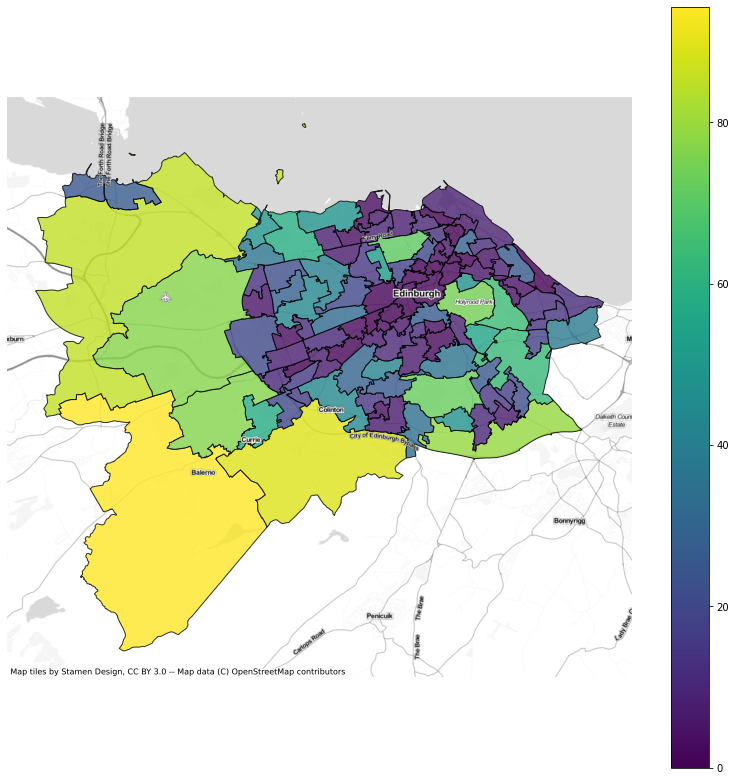

In [31]:
# map
ax = msoa.to_crs("epsg:3857").plot("Green", figsize=(14, 14), alpha=0.8, edgecolor="black", legend=True)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.set_axis_off()